In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, CuDNNLSTM
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling1D
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
print(tf.__version__)

1.13.0-rc1


# Plot accuracy and loss over *time*

In [0]:
def plot_hist(history):
  history_dict = history.history
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  
  plt.clf() #clear figure
  plt.plot(epochs, loss, 'b', label = 'Training loss')
  plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
  plt.clf()
  plt.plot(epochs, acc, 'b', label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()
  


# Download dataset

In [0]:
vocab_size = 10000
(train_data, train_labels), (test_data, test_labels) = \
    keras.datasets.imdb.load_data(num_words=vocab_size)

In [0]:
# a dictionary mapping words --> integer index
word_index = keras.datasets.imdb.get_word_index()
# shift word index by 3 because we want to add special words
word_index = {k:(v+3) for k, v in word_index.items()}
word_index["<PAD>"] = 0 # padding
word_index["<SOS>"] = 1 # start of sequence
word_index["<UNK>"] = 2 # unknown (out of the top 1000 most frequent words)


In [0]:
# build another dictionary of mapping integer -->words, reverse indexs and values
reverse_word_index = dict([(k,v) for (v,k) in word_index.items()])
# creat a helper function to convert the integer to words
# also limit max length
def decode_review(text):
  words = [reverse_word_index.get(i, "<UNK>") for i in text] # return UNK when words not found in the dictionary
  fixed_width_string = []
  # limit max length = 10
  for w_pos in range(len(words)):
    fixed_width_string.append(words[w_pos])
    if (w_pos+1) % 10 == 0:
      fixed_width_string.append('\n')
  return ' '.join(fixed_width_string)# separate the elements in the list with whitespce

# Check content

In [62]:
print('Training data: {} reviews， {} labels'.format(len(train_data), len(train_labels)))
# print('Word IDs')
# print(train_data[0])
# print('Label')
# print(train_labels[0])
len(train_data[0]), len(train_data[1])
print(decode_review(train_data[0]))

<SOS> this film was just brilliant casting location scenery story 
 direction everyone's really suited the part they played and you 
 could just imagine being there robert <UNK> is an amazing 
 actor and now the same being director <UNK> father came 
 from the same scottish island as myself so i loved 
 the fact there was a real connection with this film 
 the witty remarks throughout the film were great it was 
 just brilliant so much that i bought the film as 
 soon as it was released for <UNK> and would recommend 
 it to everyone to watch and the fly fishing was 
 amazing really cried at the end it was so sad 
 and you know what they say if you cry at 
 a film it must have been good and this definitely 
 was also <UNK> to the two little boy's that played 
 the <UNK> of norman and paul they were just brilliant 
 children are often left out of the <UNK> list i 
 think because the stars that play them all grown up 
 are such a big profile for the whole film but 
 these children are ama

# Prepare the data for input

In [0]:
# padding before the sentence and cut the number of words at 100
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value = word_index['<PAD>'],
                                                       padding = 'pre',
                                                       truncating = 'pre',
                                                       maxlen = 100)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                     value = word_index['<PAD>'],
                                                     padding = 'pre',
                                                     truncating = 'pre',
                                                     maxlen = 100)

In [82]:
# text after padding and truncated
(len(train_data[0]), len(train_data[1]))
print(decode_review(train_data[0]))

cry at a film it must have been good and 
 this definitely was also <UNK> to the two little boy's 
 that played the <UNK> of norman and paul they were 
 just brilliant children are often left out of the <UNK> 
 list i think because the stars that play them all 
 grown up are such a big profile for the whole 
 film but these children are amazing and should be praised 
 for what they have done don't you think the whole 
 story was so lovely because it was true and was 
 someone's life after all that was shared with us all 



# Create a validation set

In [0]:
# choose the first 1000 data to be the validation set
x_val = train_data[:1000]
partial_x_train = train_data[1000:]
y_val = train_labels[:1000]
partial_y_train = train_labels[1000:]

# Build the LSTM Bidirectioinal model

## Use pretrained GloVe word embedding 

In [0]:
import os
os.chdir('/content')
pretrained_embedding_matrix = (np.random.rand(vocab_size, 100) - 0.5) / 1e4

# construct pre_trained matrix
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        if word in word_index:
            embs = np.asarray(values[1:], dtype='float32')
            if word_index[word] >= vocab_size: continue #return to the start of loop
            pretrained_embedding_matrix[word_index[word]] = embs

In [197]:
# the element in each batch/text will be represented as on-hot-encoding
# we have 10000 vocabulary, which mean each element will be 10000 dimension,
# thus, use embedding to embed each element to 100 dimension
model = None
K.clear_session()
model = keras.Sequential()

model.add(Embedding(vocab_size, 100, weights=[pretrained_embedding_matrix]))

model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.6))) #return output to be as input of next LSTM
model.add(Bidirectional(LSTM(32, return_sequences=True, recurrent_dropout=0.6)))
model.add(Bidirectional(LSTM(32, return_sequences=False, recurrent_dropout=0.6)))

model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

model.compile(optimizer=tf.train.AdamOptimizer(),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          34048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,083,777
Trainable params: 1,083,777
Non-trainable params: 0
_________________________________________________________________


# Train the  model

In [198]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 3,
                   batch_size = 50,
                   validation_data = (x_val, y_val))


Train on 24000 samples, validate on 1000 samples
Epoch 1/3
24000/24000 [==============================] - 567s 24ms/sample - loss: 0.5362 - acc: 0.7109 - val_loss: 0.3711 - val_acc: 0.8380
Epoch 2/3
24000/24000 [==============================] - 561s 23ms/sample - loss: 0.3275 - acc: 0.8640 - val_loss: 0.3322 - val_acc: 0.8460
Epoch 3/3
24000/24000 [==============================] - 562s 23ms/sample - loss: 0.2523 - acc: 0.9030 - val_loss: 0.3232 - val_acc: 0.8640


In [199]:
results = model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 197s 8ms/sample - loss: 0.3399 - acc: 0.8551
loss is: 0.33992352935791015 accuracy is:0.8551200032234192 on test set


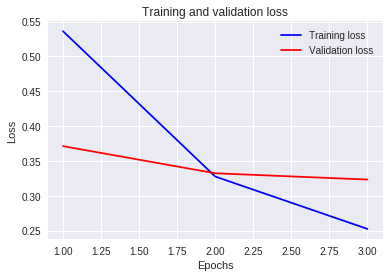

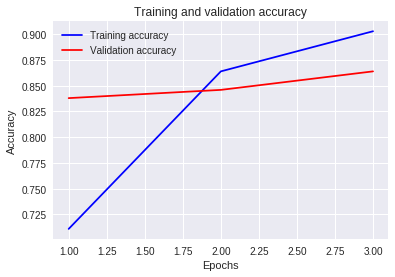

In [200]:
# plot the learning curve
plot_hist(history)

In [203]:
print('loss is: {} accuracy is:{} on test set'.format(results[0], results[1]))

loss is: 0.33992352935791015 accuracy is:0.8551200032234192 on test set
